# Installation
You do not have to follow our installation instructions if you have roughly equivalent setups / environments already.

We will use Conda and Pip to help us install packages for this homework. If you do not have Miniconda or Anaconda, you can install Miniconda from here https://docs.conda.io/en/latest/miniconda.html.

```
conda create --name exercise2 python=3.7
conda activate exercise2

pip install jupyter
```

Go to https://pytorch.org/ to install PyTorch if you don't have it already

To install the Hugging Face `transformers` library, run
```
pip install transformers
```

Follow the instructions from https://docs.dgl.ai/en/0.4.x/install/ to install Deep Graph Library (DGL).

Spin up jupyter notebook with
```
jupyter notebook
```

# Exercise
Our exercise is an implementation of the paper [Graph-to-Tree Learning for Solving Math Word Problems](https://www.aclweb.org/anthology/2020.acl-main.362.pdf), which solves math word problems in the MAWPS dataset. Please run `demo.ipynb` for some visualizations of the overall pipeline. We recommend that you read the original paper as well if necessary.

## Provided Components
1. We provide the entire input and output processing pipeline for you, as described in `demo.ipynb`.
2. We provide a fully implemented custom implementation of the transformer in the `TransformerBlock` class.
3. We provide a partially implemented graph convolutional network in the `GCN` class.
4. We provide a fully implemented tree decoding network in `TreeDecoder`. The tree decoding logic in `train` and `evaluate` is fully implemented.
5. If `use_t5 = 'small'`, `setup` will load in a pretrained `t5-small` into the variable `t5_model`.

## Tasks
Your tasks are
1. Use Deep Graph Library (DGL) to complete the graph convolution network. Keep `use_t5 = None` for this part. The baseline performance obtained by the TA is 0.74 test value accuracy. Report test accuracies for at least 5 sets of hyperparameters.
2. Use Hugging Face `transformers` library to replace the custom transformer base model with a pre-trained `t5-small` model. Set `use_t5 = 'small'` for this part. The baseline performance obtained by the TA is 0.78 test value accuracy. Report test accuracies for at least 5 sets of hyperparameters.
3. Change any part of the code (e.g. hyperparameter, architecture, training data, etc.) to optimize the performance of at least one of the transformers (custom or T5) to be better than the baseline performance.

Note that for parts 1 and 2, you should not change any provided component at all. For part 3, you may change any part of the code as long as your model is not "cheating" (e.g. fitting on the test set).

For each of these parts, please run all the cells below (they are all definition cells except the last cell). When you run the training loop without completing some required part of the exercise, the code will throw a `NotImplementedError`; you should fill out the required code to fix this error, then run the training loop again.

In [1]:
# !pip install 'sentencepiece==0.1.91' --force-reinstall 
# run this if some error occurs; code breaks with newer package version

     |████████████████████████████████| 1.1 MB 4.3 MB/s eta 0:00:01
  Attempting uninstall: sentencepiece
    Found existing installation: sentencepiece 0.1.92
    Uninstalling sentencepiece-0.1.92:
      Successfully uninstalled sentencepiece-0.1.92


In [19]:
from transformers import T5Tokenizer,T5Model

In [20]:
from copy import copy
from tqdm import tqdm, trange
import itertools

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F


import dgl
from dgl.nn import GraphConv
false = False
true = True
NaN = float("NaN")

from util import setup, check_match

# Converting Inputs to Torch Tensors

In [21]:
def tensorize_data(train_data, test_data):
    for d in itertools.chain(train_data, test_data):
        d['in_idxs'] = torch.tensor([in_vocab.token2idx.get(x, in_vocab.unk) for x in d['in_tokens']])
        d['out_idxs'] = torch.tensor([out_vocab.token2idx.get(x, out_vocab.unk) for x in d['out_tokens']])
        d['n_in'] = n_in = len(d['in_idxs'])
        d['n_out'] = len(d['out_idxs'])
        d['n_nP'] = n_nP = len(d['nP'])
        d['nP_in_mask'] = mask = torch.zeros(n_in, dtype=torch.bool)
        mask[d['nP_positions']] = True
        d['nP_out_mask'] = mask = torch.zeros(n_max_nP, dtype=torch.bool)
        mask[:n_nP] = True
        d['qcomp_edges'] = get_quantity_comparison_edges(d)
        d['qcell_edges'] = get_quantity_cell_edges(d)

def get_quantity_comparison_edges(d):
    quants = [float(x) for x in d['nP']]
    quant_positions = d['nP_positions']
#     assert max(quant_positions) < d['n_in']
    adj_matrix = torch.eye(d['n_in'], dtype=np.bool)
    for x, x_pos in zip(quants, quant_positions):
        for y, y_pos in zip(quants, quant_positions):
            adj_matrix[x_pos, y_pos] |= x > y
    """
    Convert the adjacency matrix of the directed graph into a tuple of (src_edges, dst_edges), which
    is the input format of dgl.graph (see https://docs.dgl.ai/generated/dgl.graph.html).
    Hint: check out the 'nonzero' function
    """
    return adj_matrix.nonzero(as_tuple=True)

def get_quantity_cell_edges(d):
    in_idxs = d['in_idxs']
    quant_positions = d['nP_positions']
    quant_cell_positions = d['quant_cell_positions']
    assert max(quant_cell_positions) < d['n_in']
    word_cells = set(quant_cell_positions) - set(quant_positions)
    adj_matrix = torch.eye(d['n_in'], dtype=torch.bool)
    for w_pos in word_cells:
        for q_pos in quant_positions:
            if abs(w_pos - q_pos) < 4:
                adj_matrix[w_pos, q_pos] = adj_matrix[q_pos, w_pos] = True
    pos_idxs = in_idxs[quant_cell_positions]
    for idx1, pos1 in zip(pos_idxs, quant_cell_positions):
        for idx2, pos2 in zip(pos_idxs, quant_cell_positions):
            if idx1 == idx2:
                adj_matrix[pos1, pos2] = adj_matrix[pos2, pos1] = True
    """
    Convert the adjacency matrix of the directed graph into a tuple of (src_edges, dst_edges), which
    is the input format of dgl.graph (see https://docs.dgl.ai/generated/dgl.graph.html).
    Hint: check out the 'nonzero' function
    """
    return adj_matrix.nonzero(as_tuple=True)

# Model

In [22]:
class TransformerAttention(nn.Module):
    """
    Used in Transformer Block
    """
    def __init__(self):
        super().__init__()
        self.qkv = nn.Linear(n_hid, n_head * (n_k * 2 + n_v))
        self.out = nn.Linear(n_head * n_v, n_hid)

    def forward(self, x, mask=None):
        n_batch, n_batch_max_in, n_hid = x.shape
        q_k_v = self.qkv(x).view(n_batch, n_batch_max_in, n_head, 2 * n_k + n_v).transpose(1, 2)
        q, k, v = q_k_v.split([n_k, n_k, n_v], dim=-1)

        q = q.reshape(n_batch * n_head, n_batch_max_in, n_k)
        k = k.reshape_as(q).transpose(1, 2)
        qk = q.bmm(k) / np.sqrt(n_k)

        if mask is not None:
            qk = qk.view(n_batch, n_head, n_batch_max_in, n_batch_max_in).transpose(1, 2)
            qk[~mask] = -np.inf
            qk = qk.transpose(1, 2).view(n_batch * n_head, n_batch_max_in, n_batch_max_in)
        qk = qk.softmax(dim=-1)
        v = v.reshape(n_batch * n_head, n_batch_max_in, n_v)
        qkv = qk.bmm(v).view(n_batch, n_head, n_batch_max_in, n_v).transpose(1, 2).reshape(n_batch, n_batch_max_in, n_head * n_v)
        out = self.out(qkv)
        return x + out

class TransformerBlock(nn.Module):
    """
    Custom Transformer
    """
    def __init__(self):
        super().__init__()
        self.attn = TransformerAttention()
        n_inner = n_hid * 4
        self.inner = nn.Sequential(
            nn.Linear(n_hid, n_inner),
            nn.ReLU(inplace=True),
            nn.Linear(n_inner, n_hid)
        )

    def forward(self, x, mask=None):
        x = x + self.attn(x, mask=mask)
        return x + self.inner(x)
    
class GCNBranch(nn.Module):
    def __init__(self, n_hid_in, n_hid_out, dropout=0.3):
        super().__init__()
        """
        Define a branch of the graph convolution with
        1. GraphConv from n_hid_in to n_hid_in
        2. ReLU
        3. Dropout
        4. GraphConv from n_hid_in to n_hid_out
        
        Note: your should call GraphConv with allow_zero_in_degree=True
        """
        self.gc1 = GraphConv(n_hid_in, n_hid_in, allow_zero_in_degree=True)
        self.drelu = nn.Sequential(
            nn.ReLU(inplace=True),
            nn.Dropout(dropout)
        )
        self.gc2 = GraphConv(n_hid_in, n_hid_out, allow_zero_in_degree=True)

    def forward(self, x, graph):
        """
        Forward pass of your defined branch above
        """
        return self.gc2(graph, self.drelu(self.gc1(graph, x)))

class GCN(nn.Module):
    def __init__(self, n_head=4, dropout=0.3):
        super().__init__()
        self.branches = nn.ModuleList(GCNBranch(n_hid, n_hid // n_head, dropout) for _ in range(n_head))

        self.feed_forward = nn.Sequential(
            nn.Linear(n_hid, n_hid),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            nn.Linear(n_hid, n_hid)
        )
        self.layer_norm = nn.LayerNorm(n_hid)

    def forward(self, h, gt_graph, attr_graph):
        x = h.reshape(-1, n_hid)
        graphs = [gt_graph, gt_graph, attr_graph, attr_graph]
        x = torch.cat([branch(x, g) for branch, g in zip(self.branches, graphs)], dim=-1).view_as(h)
        x = h + self.layer_norm(x)
        return x + self.feed_forward(x)

class Gate(nn.Module):
    def __init__(self, n_in, n_out):
        super(Gate, self).__init__()
        self.t = nn.Linear(n_in, n_out)
        self.s = nn.Linear(n_in, n_out)

    def forward(self, x):
        return self.t(x).tanh() * self.s(x).sigmoid()

class TreeDecoder(nn.Module):
    def __init__(self, dropout=0.5):
        super().__init__()
        drop = nn.Dropout(dropout)
        self.constant_embedding = nn.Parameter(torch.randn(1, out_vocab.n_constants, n_hid))

        self.qp_gate = nn.Sequential(drop, Gate(n_hid, n_hid))
        self.gts_right = nn.Sequential(drop, Gate(2 * n_hid, n_hid))

        self.attn_fc = nn.Sequential(drop,
            nn.Linear(2 * n_hid, n_hid),
            nn.Tanh(),
            nn.Linear(n_hid, 1)
        )
        self.quant_fc = nn.Sequential(drop,
            nn.Linear(n_hid * 3, n_hid),
            nn.Tanh(),
            nn.Linear(n_hid, 1, bias=False)
        )
        self.op_fc = nn.Sequential(drop, nn.Linear(n_hid * 2, out_vocab.n_ops))

        self.op_embedding = nn.Embedding(out_vocab.n_ops + 1, n_hid, padding_idx=out_vocab.n_ops)
        self.gts_left = nn.Sequential(drop, Gate(n_hid * 2 + n_hid, n_hid))
        self.gts_left_qp = nn.Sequential(drop, Gate(n_hid * 2 + n_hid, n_hid), self.qp_gate)

        self.subtree_gate = nn.Sequential(drop, Gate(n_hid * 2 + n_hid, n_hid))

    def gts_attention(self, q, zbar, in_mask=None):
        attn_score = self.attn_fc(
            torch.cat([q.unsqueeze(1).expand_as(zbar), zbar], dim=2)
        ).squeeze(2)
        if in_mask is not None:
            attn_score[~in_mask] = -np.inf
        attn = attn_score.softmax(dim=1)
        return (attn.unsqueeze(1) @ zbar).squeeze(1) # (n_batch, n_hid)

    def gts_predict(self, qp_Gc, quant_embed, nP_out_mask=None):
        quant_score = self.quant_fc(
            torch.cat([qp_Gc.unsqueeze(1).expand(-1, quant_embed.size(1), -1), quant_embed], dim=2)
        ).squeeze(2)
        op_score = self.op_fc(qp_Gc)
        pred_score = torch.cat((op_score, quant_score), dim=1)
        if nP_out_mask is not None:
            pred_score[:, out_vocab.base_nP:][~nP_out_mask] = -np.inf
        return pred_score

    def merge_subtree(self, op, tl, yr):
        return self.subtree_gate(torch.cat((op, tl, yr), dim=-1))

class Model(nn.Module):
    def __init__(self, dropout=0.5):
        super().__init__()
        drop = nn.Dropout(dropout)

        if use_t5:
            """
            Use t5_model.encoder as the encoder for this model. Note that unlike the custom transformer, you don't
            need to use an external positional embedding for the T5 transformer (i.e. don't define self.pos_emb)
            
            You may specify layer weights to freeze during finetuning by modifying the freeze_layers global variable
            """
            self.t5_encoder = t5_model.encoder
            
            for i_layer, block in enumerate(self.t5_encoder.block):
                if i_layer in freeze_layers:
                    for param in block.parameters():
                        param.requires_grad = False
        else:
            self.in_embed = nn.Sequential(nn.Embedding(in_vocab.n, n_hid, padding_idx=in_vocab.pad), drop)
            self.pos_embed = nn.Embedding(1 + n_max_in, n_hid) # Use the first position as global vector
            self.transformer_layers = nn.ModuleList(TransformerBlock() for _ in range(n_layers))

        self.gcn = GCN()

        self.decoder = TreeDecoder()

        if not use_t5:
            self.apply(self.init_weight)

    def init_weight(self, m):
        if type(m) in [nn.Embedding]:
            nn.init.normal_(m.weight, 0, 0.1)

    def encode(self, in_idxs, n_in, gt_graph, attr_graph, in_mask=None):
        in_idxs_pad = F.pad(in_idxs, (1, 0), value=in_vocab.pad)
        if use_t5:
            """
            Call your T5 encoder
            """
#             h, = self.t5_encoder(in_idxs_pad)
            h = self.t5_encoder(in_idxs_pad).last_hidden_state
        else:
            x = self.in_embed(in_idxs_pad) # (n_batch, n_batch_max_in, n_hid)
            h = x + self.pos_embed(torch.arange(x.size(1), device=x.device))
            for layer in self.transformer_layers:
                h = layer(h, mask=in_mask)
        zg, h = h[:, 0], h[:, 1:]
        zbar = self.gcn(h, gt_graph, attr_graph)
        return zbar, zg

# Training a Batch

In [23]:
class Node:
    def __init__(self, up):
        self.up = up
        self.is_root = up is None
        self.left = self.right = None
        self.ql = self.tl = self.op = None

def train(batch, model, opt):
    n_batch = len(batch)

    n_in = [d['n_in'] for d in batch]
    pad = lambda x, value: nn.utils.rnn.pad_sequence(x, batch_first=True, padding_value=value)
    in_idxs = pad([d['in_idxs'] for d in batch], in_vocab.pad).to(device)
    in_mask = pad([torch.ones(n, dtype=torch.bool) for n in n_in], False).to(device)
    nP_in_mask = pad([d['nP_in_mask'] for d in batch], False).to(device)
    nP_out_mask = torch.stack([d['nP_out_mask'] for d in batch]).to(device)
    
    qcomp_graph, qcell_graph = [], []
    for d in batch:
        """
        Create qcomp_graph and qcell_graph from d['qcomp_edges'] and d['qcell_edges'] by calling dgl.graph
        (see https://docs.dgl.ai/generated/dgl.graph.html)

        Note that num_nodes needs to be set to the maximum input length in this batch
        """
        ### Your code here ###
        qcomp_graph_i = dgl.graph(d['qcomp_edges'], num_nodes=in_idxs.size(1), device=device)
        qcell_graph_i = dgl.graph(d['qcell_edges'], num_nodes=in_idxs.size(1), device=device)
        
        qcomp_graph.append(qcomp_graph_i)
        qcell_graph.append(qcell_graph_i)
    qcomp_graph = dgl.batch(qcomp_graph)
    qcell_graph = dgl.batch(qcell_graph)
    
    label = pad([d['out_idxs'] for d in batch], out_vocab.pad)
    nP_candidates = [d['nP_candidates'] for d in batch]

    zbar, qroot = model.encode(in_idxs, n_in, qcomp_graph, qcell_graph, in_mask=None)
    z_nP = zbar.new_zeros((n_batch, n_max_nP, n_hid))
    z_nP[nP_out_mask] = zbar[nP_in_mask]

    decoder = model.decoder

    n_quant = out_vocab.n_constants + n_max_nP
    quant_embed = torch.cat([decoder.constant_embedding.expand(n_batch, -1, -1), z_nP], dim=1) # (n_batch, n_quant, n_hid)

    nodes = np.array([Node(None) for _ in range(n_batch)])
    op_min, op_max = out_vocab.base_op, out_vocab.base_op + out_vocab.n_ops
    quant_min, quant_max = out_vocab.base_quant, out_vocab.base_quant + n_quant

    # Initialize root node vector according to zg (the global context)
    qp = decoder.qp_gate(qroot)
    scores = []
    for i, label_i in enumerate(label.T): # Iterate over the output positions
        Gc = decoder.gts_attention(qp, zbar, in_mask)
        qp_Gc = torch.cat([qp, Gc], dim=1) # (n_batch, 2 * n_hid)

        score = decoder.gts_predict(qp_Gc, quant_embed, nP_out_mask)
        scores.append(score)

        # Whether the label is an operator
        is_op = (op_min <= label_i) & (label_i < op_max)
        # Whether the label is a quantity
        is_quant = ((quant_min <= label_i) & (label_i < quant_max)) | (label_i == out_vocab.unk)

        op_embed = decoder.op_embedding((label_i[is_op] - out_vocab.base_op).to(device))
        qp_Gc_op = torch.cat([qp_Gc[is_op], op_embed], dim=1)

        is_left = np.zeros(n_batch, dtype=np.bool)
        qleft_qp = decoder.gts_left_qp(qp_Gc_op)
        qleft = decoder.gts_left(qp_Gc_op)
        for j, ql, op in zip(is_op.nonzero(as_tuple=True)[0], qleft, op_embed):
            node = nodes[j]
            nodes[j] = node.left = Node(node)
            node.op = op
            node.ql = ql
            is_left[j] = True

        is_right = np.zeros(n_batch, dtype=np.bool)
        nP_score = score[:, out_vocab.base_nP:].detach().cpu()
        ql_tl = []
        for j in is_quant.nonzero(as_tuple=True)[0]:
            if label_i[j] == out_vocab.unk:
                candidates = nP_candidates[j][i]
#                 label_i[j] = out_vocab.base_nP + candidates[nP_score[j, candidates].argmax()]
                label_i[j] = torch.from_numpy(np.array(out_vocab.base_nP + candidates[nP_score[j, candidates].argmax()])).to(label_i)

            node = nodes[j]
            pnode = node.up
            t = quant_embed[j, label_i[j] - out_vocab.base_quant]
            while pnode and pnode.right is node:
                t = decoder.merge_subtree(pnode.op, pnode.tl, t) # merge operator, left subtree, and right child
                node, pnode = pnode, pnode.up # backtrack to parent node
            if pnode is None: # Finished traversing tree of j
                continue
            # Now pnode.left is node. t is the tl representing the left subtree of pnode
            pnode.tl = t
            ql_tl.append(torch.cat([pnode.ql, pnode.tl])) # For computing qright
            nodes[j] = pnode.right = Node(pnode)
            is_right[j] = True

        qp = torch.zeros((n_batch, n_hid), device=device)
        qp[is_left] = qleft_qp
        if ql_tl:
            qp[is_right] = decoder.gts_right(torch.stack(ql_tl))

    label = label.to(device).view(-1)
    scores = torch.stack(scores, dim=1).view(-1, out_vocab.n_ops + n_quant)
    loss = F.cross_entropy(scores, label, ignore_index=out_vocab.pad)

    opt.zero_grad()
    loss.backward()
    opt.step()
    return loss.item()

# Evaluation

In [24]:
class BeamNode(Node):
    def __init__(self, up, prev, qp, token=None):
        super().__init__(up)
        self.prev = prev
        self.qp = qp
        self.token = token

    def trace_tokens(self, *last_token):
        if self.prev is None:
            return list(last_token)
        tokens = self.prev.trace_tokens()
        tokens.append(self.token)
        tokens.extend(last_token)
        return tokens

def evaluate(d, model, beam_size=5, n_max_out=45):
    in_idxs = d['in_idxs'].unsqueeze(0).to(device=device)
    """
    Create qcomp_graph and qcell_graph from d['qcomp_edges'] and d['qcell_edges'] by calling dgl.graph
    (see https://docs.dgl.ai/generated/dgl.graph.html)
    """
#     qcomp_graph = dgl.graph(d['gt_edges'], device=device)
#     qcell_graph = dgl.graph(d['attr_edges'], device=device)
    qcomp_graph = dgl.graph(d['qcomp_edges'], device=device)
    qcell_graph = dgl.graph(d['qcell_edges'], device=device)

    zbar, qroot = model.encode(in_idxs, [d['n_in']], qcomp_graph, qcell_graph)
    z_nP = zbar[:, d['nP_positions']]

    decoder = model.decoder

    quant_embed = torch.cat([decoder.constant_embedding, z_nP], dim=1) # (1, n_quant, n_hid)
    op_min, op_max = out_vocab.base_op, out_vocab.base_op + out_vocab.n_ops

    best_done_beam = (-np.inf, None, None)
    beams = [(0, BeamNode(up=None, prev=None, qp=decoder.qp_gate(qroot)))]
    for _ in range(n_max_out):
        new_beams = []
        for logp_prev, node in beams:
            Gc = decoder.gts_attention(node.qp, zbar)
            qp_Gc = torch.cat([node.qp, Gc], dim=1) # (2 * n_hid,)

            log_prob = decoder.gts_predict(qp_Gc, quant_embed).log_softmax(dim=1)
            top_logps, top_tokens = log_prob.topk(beam_size, dim=1)
            for logp_token_, out_token_ in zip(top_logps.unbind(dim=1), top_tokens.unbind(dim=1)):
                out_token = out_token_.item()
                logp = logp_prev + logp_token_.item()
                if op_min <= out_token < op_max:
                    op_embed = decoder.op_embedding(out_token_)
                    qp_Gc_op = torch.cat([qp_Gc, op_embed], dim=1)
                    prev_node = copy(node)
                    next_node = prev_node.left = BeamNode(
                        up=prev_node, prev=prev_node,
                        qp=decoder.gts_left_qp(qp_Gc_op),
                        token=out_token
                    )
                    prev_node.op = op_embed
                    prev_node.ql = decoder.gts_left(qp_Gc_op)
                else:
                    pnode, prev_node = node.up, node
                    t = quant_embed[:, out_token - out_vocab.base_quant]
                    while pnode and pnode.tl is not None:
                        t = decoder.merge_subtree(pnode.op, pnode.tl, t)
                        node, pnode = pnode, pnode.up
                    if pnode is None:
                        best_done_beam = max(best_done_beam, (logp, prev_node, out_token))
                        continue
                    pnode = copy(pnode)
                    pnode.tl = t
                    next_node = pnode.right = BeamNode(
                        up=pnode, prev=prev_node,
                        qp=decoder.gts_right(torch.cat([pnode.ql, pnode.tl], dim=1)),
                        token=out_token
                    )
                new_beams.append((logp, next_node))
        beams = sorted(new_beams, key=lambda x: x[0], reverse=True)[:beam_size]
        done_logp, done_node, done_last_token = best_done_beam
        if not len(beams) or done_logp >= beams[0][0]:
            break
    return done_node.trace_tokens(done_last_token)

# Load Setup

In [25]:
# use_t5 = 'small' # Value should be None, 'small', or 'base'
use_t5 = None
usingT5 = "" if use_t5 is None else "_t5"
dataset_name = "ml_data_12_topics"

n_max_in = 100
n_epochs = 30
n_batch = 64
learning_rate = 1e-3
if use_t5:
    # T5 hyperparameters
    freeze_layers = []
    weight_decay = 1e-5
    n_hid = dict(small=512, base=768)[use_t5] # Do not modify unless you want to try t5-large
else:
    # Custom transformer hyperparameters
    n_layers = 3
    n_hid = 512
    n_k = n_v = 64
    n_head = 8
    weight_decay = 0
# device = 'cuda:0'
device = 'cpu'

train_data, test_data, in_vocab, out_vocab, n_max_nP, t5_model = setup(use_t5, path=f'data/{dataset_name}/train.json')

tensorize_data(train_data, test_data)

{'expression': '(0-8/(61-23))*((8/(61-23))l2)+(0-(61-23-8)/(61-23))*(((61-23-8)/(61-23))l2)', 'quant_cell_positions': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47], 'processed_question': 'Consider a 1D classification line on a 2D plane. There is a total of 61 points, 23 of which are on the right and the rest on the left of the boundary. 8 points on the left are classified positive. What is the entropy of the left region?', 'raw_question': 'Consider a 1D classification line on a 2D plane. There is a total of 61 points, 23 of which are on the right and the rest on the left of the boundary. 8 points on the left are classified positive. What is the entropy of the left region?', 'is_quadratic': False, 'Id': 29207, 'Expected': 0.7424875695421236}
{'expression': '9+(0.2*(4-9))', 'quant_cell_positions': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 1

# Training Loop

In [17]:
model = Model()
opt = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(opt, n_epochs)
model.to(device)

epoch = 0
while epoch < n_epochs:
    print('Epoch:', epoch + 1)
    model.train()
    losses = []
    for start in trange(0, len(train_data), n_batch):
        batch = sorted(train_data[start: start + n_batch], key=lambda d: -d['n_in'])
        loss = train(batch, model, opt)
        losses.append(loss)
    scheduler.step()

    print('Training loss:', np.mean(losses))

    epoch += 1
    if epoch % 2 == 0:
        model.eval()
        value_match, equation_match = [], []
        with torch.no_grad():
            for d in tqdm(test_data):
                if d['is_quadratic']: # This method is not equiped to handle equations with quadratics
                    val_match = eq_match = False
                else:
                    pred = evaluate(d, model)
                    d['pred_tokens'] = [out_vocab.idx2token[idx] for idx in pred]
                    val_match, eq_match = check_match(pred, d)
                value_match.append(val_match)
                equation_match.append(eq_match)
        print(f'Test equation accuracy {np.mean(equation_match):.3g}')
        print(f'Test value accuracy {np.mean(value_match):.3g}')
        torch.save(model.state_dict(), f'models/{dataset_name}{usingt5}/epoch-{epoch}.pth') # 2.5k each, 12 topics
    print()

  0%|          | 0/375 [00:00<?, ?it/s]

Epoch: 1


  0%|          | 0/375 [00:01<?, ?it/s]


KeyboardInterrupt: 

# Load Model Checkpoint

In [30]:
loaded_model = Model()
loaded_model.load_state_dict(torch.load("models/ml_data_12_topics/epoch-4.pth")) # model after 4 epochs without pretrained t5
# loaded_model.load_state_dict(torch.load("models/ml_data_12_topics_t5/epoch-20.pth")) # model after 20 epochs with pretrained t5

<All keys matched successfully>

In [27]:
loaded_model.eval()
value_match, equation_match = [], []
wrong_val, wrong_eqn = [], []
with torch.no_grad():
    for d in tqdm(test_data):
        if d['is_quadratic']: # This method is not equiped to handle equations with quadratics
            val_match = eq_match = False
        else:
            pred = evaluate(d, loaded_model)
            d['pred_tokens'] = [out_vocab.idx2token[idx] for idx in pred]
            val_match, eq_match = check_match(pred, d)
        value_match.append(val_match)
        equation_match.append(eq_match)
        if val_match != 0:
            wrong_val.append(d['raw_question'])
        if equation_match != 0:
            wrong_eqn.append(d['raw_question'])
print(f'Test equation accuracy {np.mean(equation_match):.3g}')
print(f'Test value accuracy {np.mean(value_match):.3g}') # v3

100%|██████████| 6000/6000 [35:37<00:00,  2.81it/s] 

Test equation accuracy 0.845
Test value accuracy 0.905


# Compute Accuracy Rates per Topic

In [29]:
wrong_val_2 = []
wrong_eqn_2 = []

for elt in wrong_val:
    elt = elt.replace(",","")
    elt = elt.replace(".", "")
    elt = elt.replace(" ","")
    elt = elt.replace("negative", "")
    elt = elt.replace("-", "")
    for i in range(10):
        elt = elt.replace(str(i),"")
    wrong_val_2.append(elt)
for elt in wrong_eqn:
    elt = elt.replace(",","")
    elt = elt.replace(".", "")
    elt = elt.replace(" ","")
    elt = elt.replace("negative", "")
    elt = elt.replace("-", "")
    for i in range(10):
        elt = elt.replace(str(i),"")
    wrong_eqn_2.append(elt)
    
wrong_val_counts = dict()
wrong_eqn_counts = dict()
for elt in wrong_val_2:
    wrong_val_counts[elt] = wrong_val_counts.get(elt, 0) + 1
for elt in wrong_eqn_2:
    wrong_eqn_counts[elt] = wrong_eqn_counts.get(elt, 0) + 1

In [33]:
question_to_topic = {'Whatisthemagnitudeofthevector[]?': 'b', 'Letaninputvectorbe[]Whatisitsmagnitude?': 'b', 'Ifx=[]whatis||x||?': 'b', 'Computethemagnitudeof[]': 'b', 'FindtheEuclidianlengthof[]': 'b', 'Howdoesaclassifierwithdecisionboundarythetaclassifyapointpifthetais()andpis()?': 'p', 'Aclassifierhasadecisionboundarywherethetais()Whatvaluedoesitclassifypwherepis()?': 'p', 'Ifthedecisionbounaryofaclassifieristhetawherethetaisequalto()howdoesitclassifypointpwherepisequalto()?': 'p', 'Apointpisclassifiedbyaclassifierwhosedecisionboundaryistheta=()Howdoesitclassifypwherepis()?': 'p', 'Ifthetaisthedecisionboundaryforsomeclassifierhowdoestheclassifierclassifyapointpwherethetais()andpis()?': 'p', 'Whatisthemarginofaclassifierwiththetabeingandtheta_beingonapointwithlabel?': 'f', 'Ifapointwithlabelwasclassifiedbyaclassifierwiththetaandtheta_whatisthemarginofthispoint?': 'f', 'Whatisthemarginonapointwithalabelifitisclassifiedbyaclassifierwiththetaandtheta_?': 'f', 'Whatisthesizeofthemarginofapointbyaclassifierwiththetaandtheta_ifthepointhaslabel?': 'f', 'ApointhaslabelComputethemarginofaclassifieronthispointLetthethetaoftheclassifierbeandthetheta_oftheclassifierbe': 'f', 'xis()thetais()andtheta_isWhatisthevalueofthetatimesxplustheta_?': 'lg', 'Whatisthevalueofthetatimesxplustheta_ifxis()thetais()andtheta_is?': 'lg', 'Letthetabe()theta_beandxbe()Computethetatimesxplustheta_': 'lg', 'Whatistheresultofthetatimesxplustheta_ifxis()thetais()andtheta_is?': 'lg', 'Ifwehavexequals()thetaequals()andtheta_equalsthenwhatistheresultofthetatimesxplustheta_?': 'lg', 'Iff(theta)istimesthetaplussquaredandthetaiswhatisf(theta)?': 'r', 'f(theta)isdefinedastimesthetaplussquaredandthetaisWhatisf(theta)?': 'r', 'f(theta)isthesquareofthesumofandtheproductofandwherethetaisWhatisf(theta)?': 'r', 'Whatisf(theta)iff(theta)isthetatimesplussquaredandthetais?': 'r', 'Iff(theta)istimesthetaplussquaredwhatisf(theta)whenthetais?': 'r', 'AneuralnetworkhasinputxwithweightwthatgoesintoneuronANeuronAalsohasinputoAthathasweightwOANeuronCinputstheoutputofneuronAwithweightwACNeuronChasalsohasinputoCthathasweightwOCNeuronsoutputthesumtheproductsofeachinputwiththeirrespectiveweightWhatistheoutputofneuronCifsiswisoAiswOAiswACisoCisandwOCis?': 'nn_i', 'AneuralnetworkhasinputxwithweightwthatgoesintoneuronANeuronAalsohasinputoAthathasweightwOANeuronCinputstheoutputofneuronAwithweightwACNeuronChasalsohasinputoCthathasweightwOCNeuronCappliesaReLUonitsoutputNeuronsoutputthesumtheproductsofeachinputwiththeirrespectiveweightWhatistheoutputofneuronCifsiswisoAiswOAiswACisoCisandwOCis?': 'nn_ii', 'IhaslengthandFhaslengthwhatisthelengthoftheresultofapplyingFtoI?': 'cnn', 'IislengthandFislengthWhatisthelengthoftheresultfromapplyingFtoI?': 'cnn', 'IfFhaslengthandIhaslengthwhatisthelengthoftheresultfromapplyingFtoI?': 'cnn', 'WhatisthelengthoftheresultfromapplyingFtoIifFhaslengthandIhaslength?': 'cnn', 'IfIislengthandFislengthcomputethelengthoftheoutputfromapplyingFtoI?': 'cnn', 'ConsideraverysimpleRNNdefinedbythefollowingequation:s_t=w*s_t+x_tGivens_=w=andx=[]whatiss_?': 'rnn', 'AnRNNisdefinedass_t=w*s_t+x_tIfs_iswisandxis[]whatiss_?': 'rnn', 'WhatistheRNNresults_ifs_iswisandxis[]ifwelets_t=w*s_t+x_t?': 'rnn', 'WedefineanRNNass_t=w*s_t+x_tWhatiss_ifs_iswisandxis[]?': 'rnn', 'Lets_bewbeandxbe[]Computes_ifs_tisw*s_t+x_t': 'rnn', 'Letastatemachinebedescribedwiththeequationss_t=f(s_(t)x_t)andy_t=g(s_t)wherex_tistheinputIfs_isf(s_(t)x_t)=(s_(t))m(x_t)andg(s_t)=*s_twhatistheoutputy_aftertheinputs[]?': 'sm_mdp', 'WhatistheupdatedQvalueofatuple(sa)ifqistheaisandtis?': 'rl', 'IfqiswhatisitsupdatedvalueafterapplyingQlearningifaisandtis?': 'rl', 'Letq=AfterQlearningwhatisqifaisandtis?': 'rl', 'IfaisandtiswhatistheQlearningvalueafterapplyingonetuple(sa)ifqis?': 'rl', 'AfterapplyingQlearningtoq=whatisitsvalue?Letthetbeandabe': 'rl', 'ConsideraDclassificationlineonaDplaneThereisatotalofpointsofwhichareontherightandtherestontheleftoftheboundarypointsontheleftareclassifiedpositiveWhatistheentropyoftheleftregion?': 'dtnn'}

In [34]:
topic_to_wrong_val = dict()
topic_to_wrong_eqn = dict()
for question in wrong_val_counts:
    topic = question_to_topic[question]
    topic_to_wrong_val[topic] = topic_to_wrong_val.get(topic, 0) + wrong_val_counts[question]
for question in wrong_eqn_counts:
    topic = question_to_topic[question]
    topic_to_wrong_eqn[topic] = topic_to_wrong_eqn.get(topic, 0) + wrong_eqn_counts[question]
topic_to_wrong_val_percent_correct = {k:1 - topic_to_wrong_val[k]/len(test_data) for k in topic_to_wrong_val}
topic_to_wrong_eqn_percent_correct = {k:1 - topic_to_wrong_eqn[k]/len(test_data) for k in topic_to_wrong_eqn}

## Value Accuracy

In [35]:
print(sum([topic_to_wrong_val_percent_correct[elt] for elt in topic_to_wrong_val_percent_correct])/(len(topic_to_wrong_val_percent_correct)+1))
print(sum([topic_to_wrong_val_percent_correct[elt] for elt in topic_to_wrong_val_percent_correct])/(len(topic_to_wrong_val_percent_correct)))
topic_to_wrong_val_percent_correct

0.8534230769230771
0.9245416666666668


{'b': 0.913,
 'p': 0.9656666666666667,
 'f': 0.9231666666666667,
 'rl': 0.9305,
 'nn_i': 0.9146666666666666,
 'lg': 0.9468333333333333,
 'cnn': 0.9196666666666666,
 'nn_ii': 0.915,
 'r': 0.9165,
 'rnn': 0.916,
 'dtnn': 0.9161666666666667,
 'sm_mdp': 0.9173333333333333}

## Equation Accuracy

In [36]:
print(sum([topic_to_wrong_eqn_percent_correct[elt] for elt in topic_to_wrong_eqn_percent_correct])/(len(topic_to_wrong_eqn_percent_correct)+1))
print(sum([topic_to_wrong_eqn_percent_correct[elt] for elt in topic_to_wrong_eqn_percent_correct])/(len(topic_to_wrong_eqn_percent_correct)))
topic_to_wrong_eqn_percent_correct

0.8461538461538461
0.9166666666666666


{'b': 0.913,
 'p': 0.9173333333333333,
 'f': 0.9183333333333333,
 'rl': 0.9151666666666667,
 'nn_i': 0.9146666666666666,
 'lg': 0.9213333333333333,
 'cnn': 0.9196666666666666,
 'nn_ii': 0.915,
 'r': 0.916,
 'rnn': 0.916,
 'dtnn': 0.9161666666666667,
 'sm_mdp': 0.9173333333333333}

## Visualize Result

In [19]:
import matplotlib.pyplot as plt
import pandas as pd

Text(0, 0.5, 'Percent Correct')

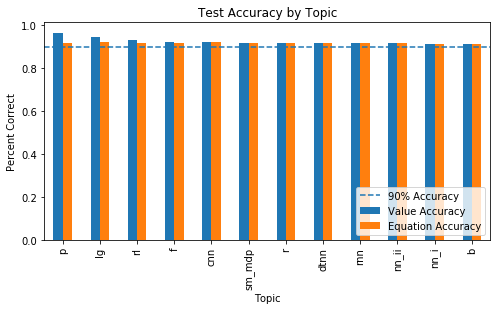

In [29]:
sorted_keys_val = sorted(tuple(topic_to_wrong_val_percent_correct),reverse=True,key=lambda x: topic_to_wrong_val_percent_correct[x])
# sorted_keys_eqn = sorted(tuple(topic_to_wrong_eqn_percent_correct),reverse=True,key=lambda x: topic_to_wrong_eqn_percent_correct[x])
plot = pd.DataFrame({"Value Accuracy": [topic_to_wrong_val_percent_correct[key] for key in sorted_keys_val],"Equation Accuracy": [topic_to_wrong_eqn_percent_correct[key] for key in sorted_keys_val]}, index=sorted_keys_val).plot(kind="bar",title="Test Accuracy by Topic",figsize=(8, 4))
plot.axhline(0.9, linestyle="dashed", label="90% Accuracy")
plot.legend(loc="lower right")
plt.xlabel("Topic")
plt.ylabel("Percent Correct")